In [1]:
import sys
sys.path.append("../../../")

import os
import json
import numpy as np
from copy import deepcopy
from collections import Counter

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

from projects.data_cleaning import *

os.makedirs("_cache", exist_ok=True)

DATABASE_DIR = '../../../outputs/all/'

# import seaborn as sns
# cmap = sns.color_palette("flare", as_cmap=True)

patients_grouped_by_admission_diagnosis_cache_path = '_cache/patients_grouped_by_admission_diagnosis.npy'
if os.path.exists(patients_grouped_by_admission_diagnosis_cache_path):
    patients_grouped_by_admission_diagnosis = np.load(
        patients_grouped_by_admission_diagnosis_cache_path, allow_pickle=True).item()
else:
    raise ValueError("cached data not found.")

# Check correlation between blood pressure changes
- CVP
- systolic blood pressure

In [2]:
dx = 'Cardiac arrest (with or without respiratory arrest; for respiratory arrest see Respiratory System)'
patients_id = patients_grouped_by_admission_diagnosis[dx]
patient = {}
for pid in patients_id:
    data = load_patient_data_by_id(DATABASE_DIR, pid)
    cvp = [val for val in data['vitalPeriodic']['cvp'] if val is not None and val == val]
    bp_sys = [val for val in data['vitalPeriodic']['systemicsystolic'] if val is not None and val == val]
    # only take the records with valid cvp and bp_sys.
    if len(cvp) and len(bp_sys):
        patient[pid] = {}
        patient[pid]['age'] = data['patient']['age'][0]
        patient[pid]['gender'] = data['patient']['gender'][0]
        patient[pid]['unitdischargestatus'] = data['patient']['unitdischargestatus'][0]
        patient[pid]['unitlengthofstay'] = data['patient']['unitdischargeoffset'][0]
        patient[pid]['vitalaperiodic'] = sort_dict(data['vitalAperiodic'], key='observationoffset')
        patient[pid]['vitalperiodic'] = sort_dict(data['vitalPeriodic'], key='observationoffset')
patient_ids = list(patient.keys())

## CVP and SysBP for a single patient.

Patient was Expired at discharge.


Text(0.5, 0, 'Offset (Day)')

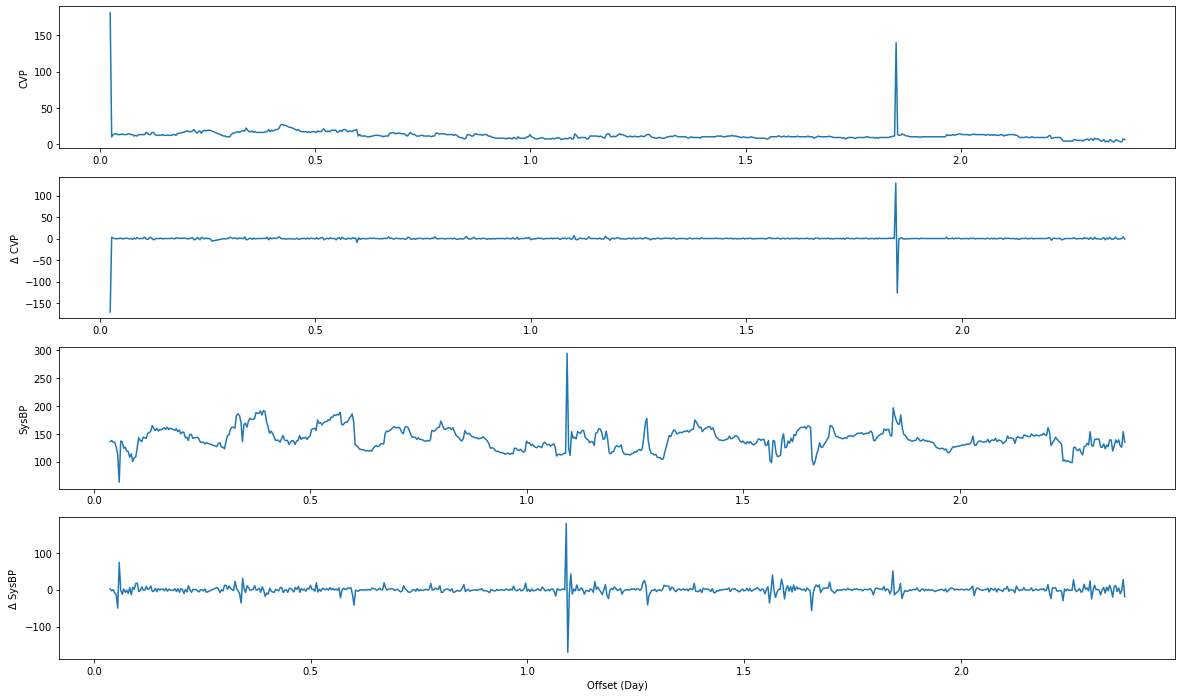

In [3]:
pid = patient_ids[350]

print(f"Patient was {patient[pid]['unitdischargestatus']} at discharge.")

cvp = patient[pid]['vitalperiodic']['cvp']
bp_sys = patient[pid]['vitalperiodic']['systemicsystolic']
ts = patient[pid]['vitalperiodic']['observationoffset']

# calculate only delta of measurements where the time interval is within 5min
# for vitalperiodic, the saved interval in the database is 5 minutes
max_interval = 5//5

delta_cvp = calculate_delta(cvp, ts, max_interval)
delta_sys = calculate_delta(bp_sys, ts, max_interval)
ts = [i/1440 for i in ts]

fig, ax = plt.subplots(4, figsize=(20, 12))
ax[0].plot(ts, cvp)
ax[0].set_ylabel("CVP")
ax[1].plot(ts, delta_cvp)
ax[1].set_ylabel(r"$\Delta$ CVP")
ax[2].plot(ts, bp_sys)
ax[2].set_ylabel("SysBP")
ax[3].plot(ts, delta_sys)
ax[3].set_ylabel(r'$\Delta$ SysBP')
ax[3].set_xlabel("Offset (Day)")

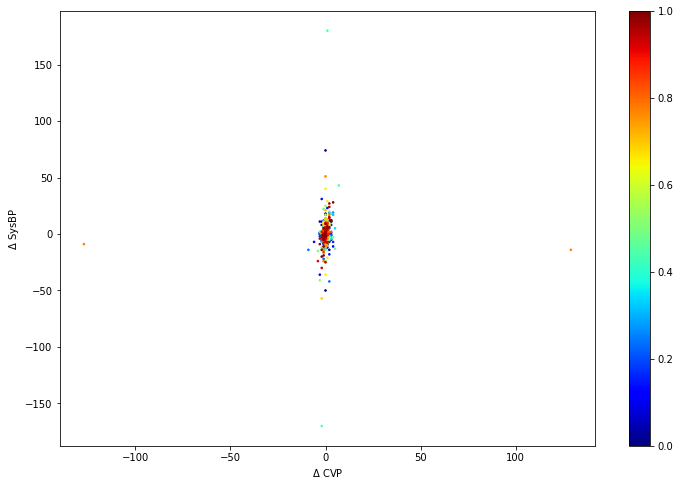

In [4]:
ts_arr = np.array(ts)
delta_cvp = np.array(delta_cvp)
delta_sys = np.array(delta_sys)
delta_cvp[delta_cvp==None] = np.nan
delta_sys[delta_sys==None] = np.nan

delta_cvp_valid = [delta_cvp[i] for i in range(len(ts)) if ~np.isnan(delta_cvp[i]) and ~np.isnan(delta_sys[i])]
delta_sys_valid = [delta_sys[i] for i in range(len(ts)) if ~np.isnan(delta_cvp[i]) and ~np.isnan(delta_sys[i])]
ts_valid = [ts[i] for i in range(len(ts)) if ~np.isnan(delta_cvp[i]) and ~np.isnan(delta_sys[i])]

# shift to 0..1
ts_valid = (ts_valid - np.min(ts_valid))/(np.max(ts_valid) - np.min(ts_valid))

fig, ax = plt.subplots(figsize=(12, 8))
points = ax.scatter(delta_cvp_valid, delta_sys_valid, c=ts_valid, marker='.', s=10, cmap='jet')
ax.set_xlabel(r"$\Delta$ CVP")
ax.set_ylabel(r"$\Delta$ SysBP")
fig.colorbar(points)

## Plot BP correlation for heart attack patients

In [5]:
delta_cvp_alive = []
delta_sys_alive = []
ts_alive = []
delta_cvp_expired = []
delta_sys_expired = []
ts_expired = []

# calculate only delta of measurements where the time interval is within 5min
# for vitalperiodic, the saved interval in the database is 5 minutes
max_interval = 5//5

for pid in patient_ids:
    cvp = patient[pid]['vitalperiodic']['cvp']
    bp_sys = patient[pid]['vitalperiodic']['systemicsystolic']
    ts = patient[pid]['vitalperiodic']['observationoffset']

    delta_cvp = calculate_delta(cvp, ts, max_interval)
    delta_sys = calculate_delta(bp_sys, ts, max_interval)

    ts_arr = np.array(ts)
    delta_cvp = np.array(delta_cvp)
    delta_sys = np.array(delta_sys)
    delta_cvp[delta_cvp==None] = np.nan
    delta_sys[delta_sys==None] = np.nan
    
    ts_valid = [ts[i] for i in range(len(ts)) if ~np.isnan(delta_cvp[i]) and ~np.isnan(delta_sys[i])]
    if len(ts_valid)/len(ts) > 0.1:
        delta_cvp_valid = [delta_cvp[i] for i in range(len(ts)) if ~np.isnan(delta_cvp[i]) and ~np.isnan(delta_sys[i])]
        delta_sys_valid = [delta_sys[i] for i in range(len(ts)) if ~np.isnan(delta_cvp[i]) and ~np.isnan(delta_sys[i])]

        # shift to 0..1
        ts_valid = (ts_valid - np.min(ts_valid))/(np.max(ts_valid) - np.min(ts_valid))

        # TODO: Why only shift the minimum values?
        # if np.min(ts_arr) < 0:
        #     ts_valid += abs(np.min(ts_valid))
        # ts_valid = ts_valid/np.max(ts_valid)

        if patient[pid]['unitdischargestatus'] == 'Alive':
            delta_cvp_alive.extend(delta_cvp_valid)
            delta_sys_alive.extend(delta_sys_valid)
            ts_alive.extend(ts_valid)
        if patient[pid]['unitdischargestatus'] == 'Expired':
            delta_cvp_expired.extend(delta_cvp_valid)
            delta_sys_expired.extend(delta_sys_valid)
            ts_expired.extend(ts_valid)

Text(0.5, 1.0, 'Heart Arrest: Alive Patients')

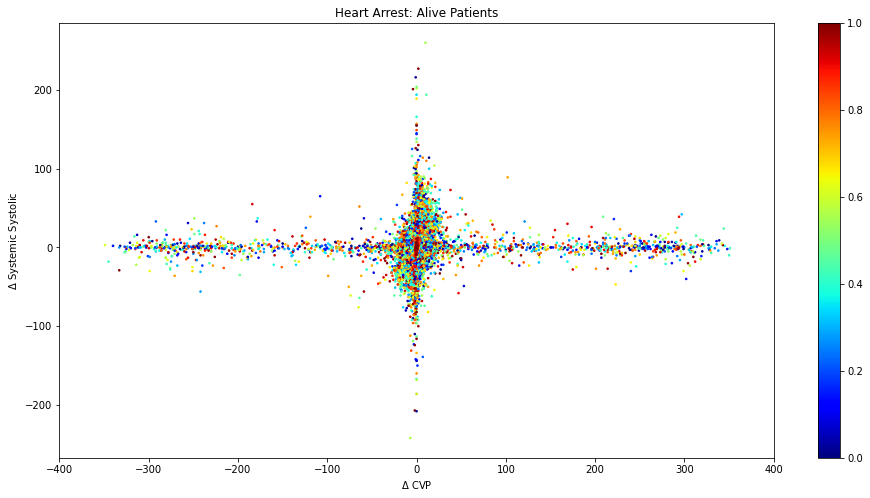

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
points = ax.scatter(delta_cvp_alive, delta_sys_alive, c=ts_alive, marker='.', s=10, cmap='jet')
fig.colorbar(points)

ax.set_xlim([-400, 400])
ax.set_xlabel(r'$\Delta$ CVP')
ax.set_ylabel(r'$\Delta$ Systemic Systolic')
ax.set_title('Heart Arrest: Alive Patients')

Text(0, 0.5, '$\\Delta$ Systemic Systolic')

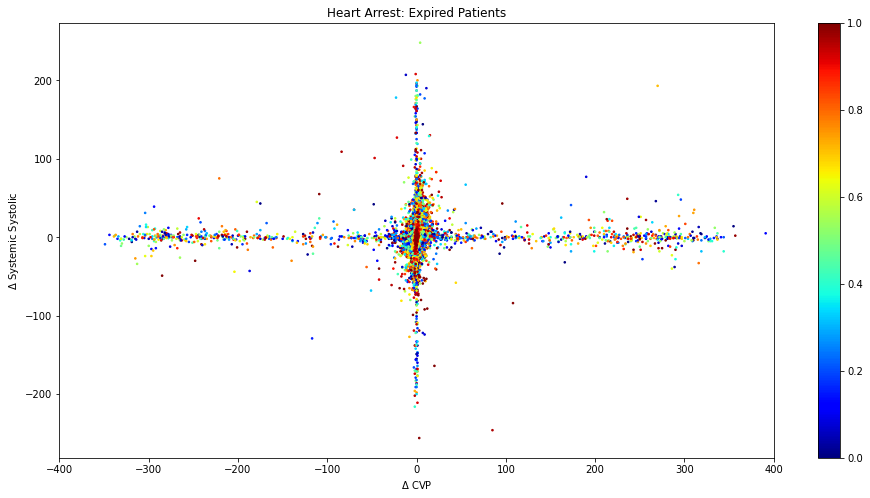

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
points = ax.scatter(delta_cvp_expired, delta_sys_expired, c=ts_expired, marker='.', s=10, cmap='jet')
fig.colorbar(points)

ax.set_xlim([-400, 400])
ax.set_title('Heart Arrest: Expired Patients')
ax.set_xlabel(r'$\Delta$ CVP')
ax.set_ylabel(r'$\Delta$ Systemic Systolic')


Text(0.5, 0, 'Systemic BP')

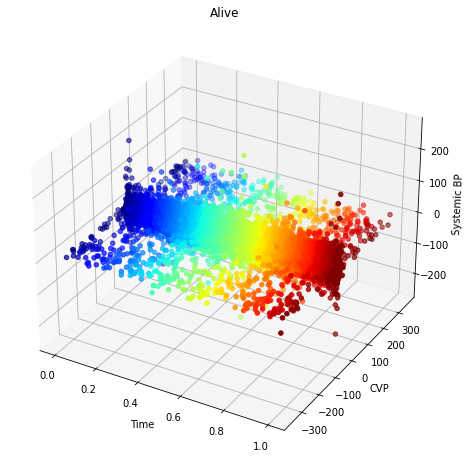

In [12]:
# %matplotlib widget
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(projection='3d', title="Alive")
ax.scatter(ts_alive, delta_cvp_alive, delta_sys_alive, c = ts_alive, cmap='jet')
ax.set_xlabel('Time')
ax.set_ylabel('CVP')
ax.set_zlabel('Systemic BP')

Text(0.5, 0, 'Systemic BP')

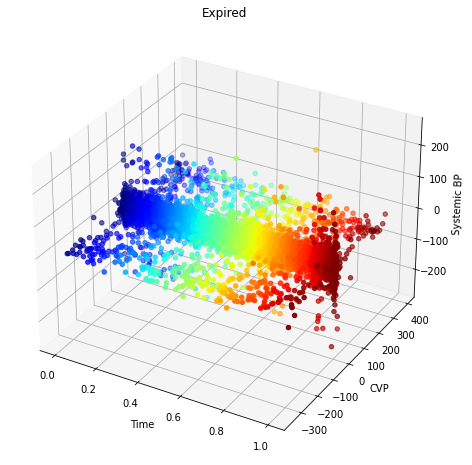

In [13]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(projection='3d', title="Expired")
ax.scatter(ts_expired, delta_cvp_expired, delta_sys_expired, c = ts_expired, cmap='jet')
ax.set_xlabel('Time')
ax.set_ylabel('CVP')
ax.set_zlabel('Systemic BP')

## Ratio between different BP changes

/tmp/ipykernel_17361/2160160247.py:3: RuntimeWarning: divide by zero encountered in true_divide
  ax[0].scatter(ts_alive, np.array(delta_cvp_alive)/np.array(delta_sys_alive), marker='.', s=2, )
/tmp/ipykernel_17361/2160160247.py:3: RuntimeWarning: invalid value encountered in true_divide
  ax[0].scatter(ts_alive, np.array(delta_cvp_alive)/np.array(delta_sys_alive), marker='.', s=2, )
/tmp/ipykernel_17361/2160160247.py:4: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].scatter(ts_expired, np.array(delta_cvp_expired)/np.array(delta_sys_expired), marker='.', s=2, )
/tmp/ipykernel_17361/2160160247.py:4: RuntimeWarning: invalid value encountered in true_divide
  ax[1].scatter(ts_expired, np.array(delta_cvp_expired)/np.array(delta_sys_expired), marker='.', s=2, )


(-500.0, 500.0)

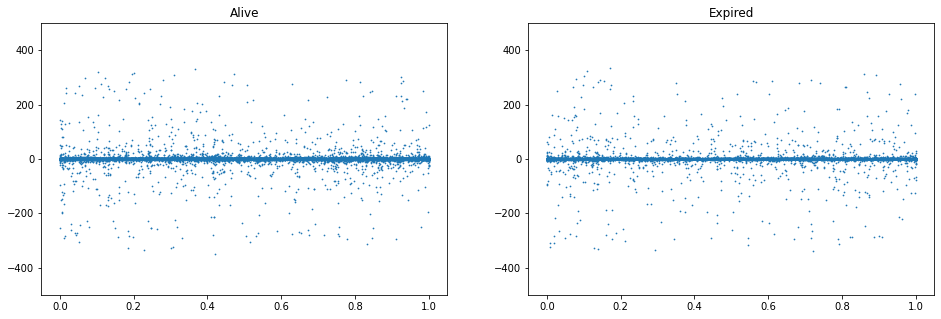

In [20]:
fig, ax = plt.subplots(1,2, figsize=(16, 5))

ax[0].scatter(ts_alive, np.array(delta_cvp_alive)/np.array(delta_sys_alive), marker='.', s=2, )
ax[1].scatter(ts_expired, np.array(delta_cvp_expired)/np.array(delta_sys_expired), marker='.', s=2, )

ax[0].set_title('Alive')
ax[1].set_title('Expired')
ax[0].set_ylim([-500, 500])
ax[1].set_ylim([-500, 500])